# Example of Kalman Filter decoders

This example is similar to those shown in "Examples_all_decoders."
However, there is some preprocessing is different for the Kalman, so we have made a separate notebook.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Run the decoders and print the goodness of fit
5. Plot example decoded outputs

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

Note that you may need to specify the path below

In [7]:
## (Configuration) Allows you to return multiple variables from a single cell ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [8]:
## Allows you to import files from another folder in current directory ## 
import os 
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.metrics import get_R2_parts

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder

## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/s/e9mul73ur9omu5f/example_data_hc.pickle?dl=0).

It is the hc-2 dataset from [crcns](https://crcns.org/data-sets/hc/hc-2). Specifically, we use the dataset "ec014.333" 


The data that we load is in the format described below. We have another example notebook, "Example_format_data_hc", that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [10]:
# Opening Acc/Dec Data 
folder='/Users/rbhatt6/Documents/MATLAB/' #ENTER THE FOLDER THAT YOUR DATA IS IN

# Decoder Velocity Outputs
with open(folder+'sortInAccDec.pickle','rb') as f:
     sort_In=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutXAccDec.pickle','rb') as f:
     sort_Out_X=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutYAccDec.pickle','rb') as f:
     sort_Out_Y=pickle.load(f,encoding='latin1') 

# Decoder Position Outputs
with open(folder+'sortOutXAccDecPos.pickle','rb') as f:
     sort_Out_X_Pos=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutYAccDecPos.pickle','rb') as f:
     sort_Out_Y_Pos=pickle.load(f,encoding='latin1') 


# Filtered SortIn data 
with open(folder+'sortInFilt.pickle','rb') as f:
     sort_In_Filt=pickle.load(f,encoding='latin1') 

sort_In

array([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [1, 0, 0, ..., 1, 0, 0],
              ...,
              [0, 0, 1, ..., 0, 0, 1],
              [0, 0, 0, ..., 0, 0, 1],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 

In [23]:
#pos
sort_Out_X_Pos[0][-1]

# vel
sort_Out_X[0][-1]

# acc
test = np.diff(sort_Out_X[0], axis = 0)
test = np.concatenate((test, test[-1:,:]), axis = 0)
test[-1]

array([24.60974452])

array([0.26383715])

array([-0.04998854])

In [18]:
# Final output is vel, acc, pos
X_Comb_Kin = []
Y_Comb_Kin = []

# Corrected decoder outputs to use (format = x,y vel, x,y acc, x,y pos)
decoder_output = []

for i in range(len(sort_Out_X)):
    # Concatenating vel with acc for X component
    temp1 = (np.diff(sort_Out_X[i], axis = 0))
    temp1 = np.concatenate((temp1,temp1[-1:,:]),axis=0)
    temp1_all_kin = np.array(np.concatenate((sort_Out_X[i], temp1, sort_Out_X_Pos[i]),axis=1))

    temp2 = (np.diff(sort_Out_Y[i], axis = 0))
    temp2 = np.concatenate((temp2,temp2[-1:,:]),axis=0)
    temp2_all_kin = np.array(np.concatenate((sort_Out_Y[i], temp2, sort_Out_Y_Pos[i]),axis=1))
    X_Comb_Kin.append(temp1_all_kin)
    Y_Comb_Kin.append(temp2_all_kin)

    temp3 = np.array(np.concatenate((sort_Out_X[i], sort_Out_Y[i], temp1, temp2, sort_Out_X_Pos[i], sort_Out_Y_Pos[i]),axis=1))

    decoder_output.append(temp3)

y_kf_X = np.array(X_Comb_Kin, dtype=object)
y_kf_Y = np.array(Y_Comb_Kin, dtype=object)

decoder_output[0].shape
decoder_output[0][-1]


(1633, 6)

array([ 2.63837147e-01, -4.04205834e-01, -4.99885401e-02, -2.30014117e-01,
        2.46097445e+01,  2.42113592e+02])

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [34]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### 3B. Format Covariates

### 3C. Take lag into account

In [ ]:
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

### 3D. Split into training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### User Options

In [35]:
#Set what part of data should be part of the training/testing/validation sets
#Note that there was a long period of no movement after about 80% of recording, so I did not use this data.
# training_range=[0, 0.5]
# valid_range=[0.5,0.65]
# testing_range=[0.65, 0.8]

training_range=[0, 0.8]
valid_range=[0.8,0.9]
testing_range=[0.9, 1]

### Split Data: For KF

### 3E. Preprocessing: Normalization and zero-centering
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

### Kalman Filter

In [17]:
sort_In
sort_In_Filt

array([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [1, 0, 0, ..., 1, 0, 0],
              ...,
              [0, 0, 1, ..., 0, 0, 1],
              [0, 0, 0, ..., 0, 0, 1],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 

array([array([[0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 1, 0, 0],
              ...,
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 1, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 1, 0, 0],
              [0, 1, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 

In [36]:
# Running decoder on X and Y components separately to get X_FVAF and Y_FVAF
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_X = run_model_kf(sort_In, X_Comb_Kin, training_range, testing_range, valid_range, "score")
Kalman_R2s_Y = run_model_kf(sort_In, Y_Comb_Kin, training_range, testing_range, valid_range, "score")

In [37]:
Kalman_R2s_X
Kalman_R2s_Y

[[0.30224871888289095, 0.2563264224976717, -0.12978992522441013],
 [0.0425781027057377, 0.27423054822769555, 0.2759103249910907],
 [-0.1461145997978346, -0.0636898547963769, -0.14575649532944523],
 [0.39496426475476343, 0.31524437274773986, 0.32836486173155466],
 [0.5603475837302112, 0.44919383670992097, 0.29546162124504827],
 [0.38825921255572315, 0.41595144359131553, -0.2905144103127697],
 [0.030658615119866783, 0.049301760760361524, -0.06618414039487419],
 [0.2974339818857974, 0.34850001312732726, -0.3798385918718499],
 [0.4112153907880485, 0.4071587771916104, 0.1577443469195008],
 [0.2478603268843509, 0.2580890569501101, 0.22209676180060844],
 [0.005734621943257134, 0.005351319765727003, -0.20566141810691607],
 [0.11988525847228904, 0.1779659261204969, 0.4831263885633016],
 [0.22200675124469138, 0.23335032850501558, -0.0817060675775747],
 [-0.008815197907430683, 0.14507591030925404, -0.17867664745616763],
 [-0.08458196268116214, -0.07640169940158348, -0.3953081054276122],
 [0.32957

[[-0.19874973399314722, -0.01997484954448625, 0.31745137439562754],
 [0.32887837897156436, 0.3135799209903194, 0.3745985073150778],
 [0.5522282059482153, 0.39409203145291805, 0.23105392868406582],
 [0.45644955547141863, 0.38173514692694677, 0.29556425515174023],
 [0.1524986981850689, 0.07535191995490409, 0.2138482807687817],
 [0.4588907100327628, 0.43608850561456747, 0.4230558799145956],
 [0.531236611269762, 0.46721934132045895, 0.16508486899968322],
 [0.38953093128724914, 0.3672655485248606, 0.4885387025536744],
 [0.1096812310917713, 0.02539443368116745, 0.49808910515615046],
 [0.4579110197866575, 0.32449129973054547, 0.38606927068823127],
 [0.5667577830583388, 0.38268574925436993, 0.36105000761489237],
 [0.2849966850919482, 0.26845754419874046, 0.3169767856530459],
 [0.19186939587100038, 0.11920302590520271, 0.4322799805072046],
 [0.24841163088774998, 0.08270095170031122, 0.37922855712951664],
 [0.19540698543411028, 0.2611833168433477, 0.23170832334091485],
 [0.2053030110479077, 0.26

In [38]:
# Running decoder on X and Y components separately to get X_FVAF and Y_FVAF -- FILTERED SORT_IN
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_X_Filt = run_model_kf(sort_In_Filt, X_Comb_Kin, training_range, testing_range, valid_range, "score")
Kalman_R2s_Y_Filt = run_model_kf(sort_In_Filt, Y_Comb_Kin, training_range, testing_range, valid_range, "score")

In [39]:
Kalman_R2s_X_Filt
Kalman_R2s_Y_Filt

[[0.2664003833008761, 0.3332095932229413, -0.12521216004917957],
 [0.041354984257004346, 0.2750630412436461, 0.1664369531412746],
 [-0.09004343935288972, 0.00363411285070403, -0.13465457189584784],
 [0.36955042659680537, 0.34703350890547036, 0.2636398553037359],
 [0.5147704949113123, 0.48869624337756956, 0.226073061054613],
 [0.38891874985267816, 0.38768388737458614, -0.25897399118216824],
 [-0.04063606250700569, -0.016119699496390805, -0.19253657878893038],
 [0.39502839377467436, 0.39669155788237853, -0.1975303043715233],
 [0.37172786190955753, 0.4514450857787836, -0.02212378732908582],
 [0.25494356049760725, 0.2754540025475444, 0.14536560740733018],
 [-0.1422175236781429, -0.0616363541015148, -0.3163170936472868],
 [0.10773141048306245, 0.19391487868049606, 0.44673260803617076],
 [-0.03159971420663288, 0.24932620953532758, -0.1351211237703258],
 [0.07890320465572254, 0.2341416873883928, -0.11322280961134523],
 [-0.25885980750024706, -0.09273037023697484, -0.6781620660091834],
 [0.258

[[-0.5732360895484476, -0.06946992072161406, 0.3925387680131325],
 [0.23392974205123074, 0.32400506604516466, 0.12870674158888784],
 [0.4166338006840917, 0.39140602480130804, 0.1676762642012012],
 [0.3472015540077973, 0.40913315613876655, 0.1604666497521362],
 [0.04103390138296459, 0.023166975174840676, 0.24332416176996863],
 [0.38515464135462585, 0.4143153940510945, 0.31833908893401675],
 [0.44821581690532486, 0.44979802865467744, 0.1197252020519376],
 [0.3185647941785109, 0.3992519046654597, 0.24872644906372565],
 [0.0010585917674461598, -0.0029112981036258923, 0.39582518113807696],
 [0.2976621136716213, 0.3324259663608612, 0.29029848870730723],
 [0.3294978410581506, 0.3936455478726435, 0.11744289648272954],
 [0.13064818485034135, 0.23541829685873805, 0.20414813750156713],
 [-0.0716394426716167, -0.048527012315711104, 0.251475116884616],
 [0.04613835905427732, 0.05090006661131852, -0.01529480000008121],
 [0.3019699042237691, 0.3702046839976991, -0.12676452252619197],
 [0.203431125058

In [7]:
# Running decoder on X and Y components together to get X_FVAF and Y_FVAF
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_combined = run_model_kf(sort_In, decoder_output, training_range, testing_range, valid_range, "score")

In [8]:
Kalman_R2s_combined

[[0.3072948830188065,
  -0.17669231556536658,
  0.25707346421119204,
  -0.02206557866297909,
  -0.14368645168103478,
  0.3367167761490708],
 [0.04923445044692665,
  0.3678399304008627,
  0.28813383938608017,
  0.335520939870686,
  0.2843216287138073,
  0.3912416398489308],
 [-0.1447917058876882,
  0.5555325950084254,
  -0.0677117693505731,
  0.3965902817403044,
  -0.16705605430987935,
  0.23086513790544516],
 [0.41535994073418503,
  0.46518368638902297,
  0.32418705629180444,
  0.38273956137804965,
  0.3311407664853778,
  0.29517090611955765],
 [0.5573915473005557,
  0.14328777331756837,
  0.44912445159968084,
  0.07344649000194425,
  0.30002028410922443,
  0.20976832788232824],
 [0.42045444307169744,
  0.46611831742599974,
  0.42273348239227715,
  0.4352488948327189,
  -0.29293346015924593,
  0.42711628396566237],
 [0.02948124874425828,
  0.5368129260854421,
  0.047542502560112054,
  0.4680191845844571,
  -0.0788187021726614,
  0.16175489763989626],
 [0.2712920312847602,
  0.413504711

In [40]:
# Running decoder on X and Y components together to get X_FVAF and Y_FVAF -- FILTERED
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_combined_Filt = run_model_kf(sort_In_Filt, decoder_output, training_range, testing_range, valid_range, "score")

In [41]:
Kalman_R2s_combined_Filt

[[0.2713886119448916,
  -0.5280610382656961,
  0.3213128834430784,
  -0.05949166783096316,
  -0.09745302431425196,
  0.3905988702448727],
 [0.044568628046299685,
  0.23252928855430843,
  0.281343575549694,
  0.3324886150457699,
  0.16823148132851706,
  0.12721566402444873],
 [-0.09698020099873927,
  0.42116847884265673,
  -0.0014806941547402808,
  0.39489051647747764,
  -0.12385306292158726,
  0.19553202588964824],
 [0.3857753539242391,
  0.3501995461371241,
  0.3639716223870806,
  0.40672845808431546,
  0.2594432797878409,
  0.15807858936153918],
 [0.5139239869251844,
  0.0382651376202543,
  0.48847347758706916,
  0.02709514889038922,
  0.22642218499681344,
  0.24375396732036858],
 [0.385914549088449,
  0.3894724686836074,
  0.39773364167841696,
  0.41419550858391063,
  -0.27460542388508347,
  0.3139505286330917],
 [-0.04387574390824578,
  0.45865412274152195,
  -0.018753236311795485,
  0.45058026389787886,
  -0.18174005559104467,
  0.1331432089670811],
 [0.3884915500472833,
  0.31534

In [9]:
# Running decoder on X and Y components together to get nom and denom for later computing combined XY_FVAF
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_XY = run_model_kf(sort_In, decoder_output, training_range, testing_range, valid_range, "parts")

In [ ]:
Kalman_R2s_XY[0].shape
range(len(Kalman_R2s_XY))

(2, 6)

range(0, 16)

In [ ]:
# Compute combined XY_FVAF (velocity only)
from Neural_Decoding.metrics import compute_XY_FVAF

XY_FVAF = []
for i in range(len(Kalman_R2s_XY)):
    #curr_bucket = Kalman_R2s_combined[i]
    vel_x_nom = Kalman_R2s_XY[i][0][0] # dim = (curr_bucket, nom, x_vel)
    vel_x_denom = Kalman_R2s_XY[i][1][0] # dim = (curr_bucket, denom, x_vel)
    vel_y_nom = Kalman_R2s_XY[i][0][1] # dim = (curr_bucket, nom, y_vel)
    vel_y_denom = Kalman_R2s_XY[i][1][1] # dim = (curr_bucket, denom, y_vel)

    curr_bucket_XY_FVAF = compute_XY_FVAF(vel_x_nom,vel_x_denom,vel_y_nom,vel_y_denom)
    XY_FVAF.append(curr_bucket_XY_FVAF)

XY_FVAF

[0.227405442543961,
 0.17364525033812173,
 0.42608821987503087,
 0.4401308773309419,
 0.4846222047779313,
 0.4384412259646876,
 0.44004068612482317,
 0.34311571051909706,
 0.34949129996278105,
 0.3491056510088656,
 0.3660772407413688,
 0.20775948373460207,
 0.22087696955016312,
 0.1255940498772361,
 0.1417788909949662,
 0.29835663464276874]

In [42]:
# Running decoder on X and Y components together to get nom and denom for later computing combined XY_FVAF
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_XY_Filt = run_model_kf(sort_In_Filt, decoder_output, training_range, testing_range, valid_range, "parts")

# Compute combined XY_FVAF (velocity only)
from Neural_Decoding.metrics import compute_XY_FVAF

XY_FVAF_Filt = []
for i in range(len(Kalman_R2s_XY_Filt)):
    #curr_bucket = Kalman_R2s_combined[i]
    vel_x_nom = Kalman_R2s_XY_Filt[i][0][0] # dim = (curr_bucket, nom, x_vel)
    vel_x_denom = Kalman_R2s_XY_Filt[i][1][0] # dim = (curr_bucket, denom, x_vel)
    vel_y_nom = Kalman_R2s_XY_Filt[i][0][1] # dim = (curr_bucket, nom, y_vel)
    vel_y_denom = Kalman_R2s_XY_Filt[i][1][1] # dim = (curr_bucket, denom, y_vel)

    curr_bucket_XY_FVAF = compute_XY_FVAF(vel_x_nom,vel_x_denom,vel_y_nom,vel_y_denom)
    XY_FVAF_Filt.append(curr_bucket_XY_FVAF)

XY_FVAF_Filt

[0.1394273009226802,
 0.11796452859785223,
 0.3253965171922609,
 0.3680880831763107,
 0.43033773656077723,
 0.38731599669257244,
 0.3627978160790374,
 0.35154871565066415,
 0.2945107712772629,
 0.26662806786149174,
 0.16114118319233328,
 0.12111160892843931,
 -0.04184773597508351,
 0.06047098800736328,
 0.15035098707028016,
 0.24456578698842535]

In [ ]:
# Determining what y_test, y_test_pred look like in order to get the right nom and denom for R^2
len(Kalman_R2s_XY)

# Iterating through the 16 buckets' validation values
Kalman_R2s_XY[0].shape

# dim1 = 16 buckets, dim2 = y_test or y_test_pred, dim3 = # of validation samples, and dim4 = 6 kinematics 
Kalman_R2s_XY[0][0][0][0]

Kalman_R2s_XY[0][:,0].shape
Kalman_R2s_XY[0][:,0]

In [ ]:
# Testing FVAF calculation on 1st bucket 

y_test = Kalman_R2s_XY[0][0]
y_test.shape
y_test_pred = Kalman_R2s_XY[0][1]
y_test_pred.shape

y_test.shape[1]
range(y_test.shape[1])

# dim = (162,6)
# Want to sum over all samples for each kinematic 
nom_list = []
for i in range(y_test.shape[1]): #Loop through outputs
    #nom = np.sum((y_test_pred[:,i]-y_test[:,i])**2) 
    nom = np.sum((y_test_pred[:,i]-y_test[:,i])**2)
    nom_list.append(nom)

nom.shape 
len(nom_list)
nom_list

In [ ]:
kf_R2s_Y_Comp = []
kf_Rho_Y_Comp = []

for i in range(len(sort_In)):
    X_kf = sort_In[i]
    y_kf = y_kf_Y[i]
    num_examples_kf=X_kf.shape[0] # nRows (b/c nCols = number of units)

    #Note that each range has a buffer of 1 bin at the beginning and end
    #This makes it so that the different sets don't include overlapping data
    training_set=np.arange(int(np.round(training_range[0]*num_examples_kf))+1,int(np.round(training_range[1]*num_examples_kf))-1)
    testing_set=np.arange(int(np.round(testing_range[0]*num_examples_kf))+1,int(np.round(testing_range[1]*num_examples_kf))-1)
    valid_set=np.arange(int(np.round(valid_range[0]*num_examples_kf))+1,int(np.round(valid_range[1]*num_examples_kf))-1)

    #Get training data
    X_kf_train=X_kf[training_set,:]
    y_kf_train=y_kf[training_set,:]

    #Get testing data
    X_kf_test=X_kf[testing_set,:]
    y_kf_test=y_kf[testing_set,:]

    #Get validation data
    X_kf_valid=X_kf[valid_set,:]
    y_kf_valid=y_kf[valid_set,:]

    #Z-score inputs 
    X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
    X_kf_train_std=np.nanstd(X_kf_train,axis=0)
    X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
    X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
    X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

    #Zero-center outputs
    y_kf_train_mean=np.mean(y_kf_train,axis=0)
    y_kf_train=y_kf_train-y_kf_train_mean
    y_kf_test=y_kf_test-y_kf_train_mean
    y_kf_valid=y_kf_valid-y_kf_train_mean

    #Declare model
    model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter (see ReadMe)

    #Fit model
    model_kf.fit(X_kf_train,y_kf_train)

    #Get predictions
    y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

    #Get metrics of fit (see read me for more details on the differences between metrics)
    #First I'll get the R^2
    R2_kf=get_R2_parts(y_kf_valid,y_valid_predicted_kf)
    #print('R2:',R2_kf[0:2]) #I'm just printing the R^2's of the 1st and 2nd entries that correspond to the positions
    kf_R2s_Y_Comp.append(R2_kf)

    #Next I'll get the rho^2 (the pearson correlation squared)
    rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
    #print('rho2:',rho_kf[0:2]**2) #I'm just printing the rho^2's of the 1st and 2nd entries that correspond to the positions
    kf_Rho_Y_Comp.append(rho_kf)

In [ ]:
# Saving results in a matlab file 

from scipy.io import savemat
import numpy

# L = [kf_R2s_X_Comp, kf_R2s_Y_Comp] # kf_Rho_X_Comp, kf_Rho_Y_Comp
L = [Kalman_R2s_combined, XY_FVAF]

FrameStack = np.empty((2,), dtype=object)
for i in range(len(L)):
    FrameStack[i] = L[i]

savemat("KalmanModelOutputsUpdated.mat", {"KalmanOutputs":FrameStack})

## 5. Make Plots

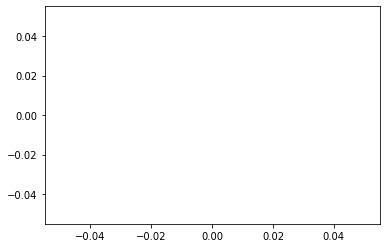

In [ ]:
#As an example, I plot an example 3000 values of the x position (column index 0), both true and predicted with the Kalman filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[2000:5000,0]+y_kf_train_mean[0],'b')
plt.plot(y_valid_predicted_kf[2000:5000,0]+y_kf_train_mean[0],'r')
#Save figure
# fig_x_kf.savefig('x_position_decoding.eps')